In [1]:
var openDigger = require('../../src/open_digger');
var now = new Date();
var res = now.setMonth(now.getMonth() - 1); // handle new year
var startYear = 2022, startMonth = 1, endYear = now.getFullYear(), endMonth = now.getMonth() + 1;
var forEveryMonth = f => {
    var index = 0;
    for (var y = startYear; y <= endYear; y++)
        for (var m = (y === startYear ? startMonth : 1); m <= (y === endYear ? endMonth : 12); m++)
            f(y, m, index++);
};

# X-lab Community Analysis Report

This notebook is used to track the members active and influence status in X-lab community.

The result can be used for community measurement and incentive.

The start date for this report is 2022-01-01 and the end date is up-to-date.

## Overview

This part is the history OpenRank trending of all projects in X-lab community.

┌─────────┬─────────────┬─────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬──────────┬──────────┬──────────┬─────────┬─────────┐
│ (index) │     id      │                name                 │ Y2022M1 │ Y2022M2 │ Y2022M3 │ Y2022M4 │ Y2022M5 │ Y2022M6 │ Y2022M7 │ Y2022M8 │ Y2022M9 │ Y2022M10 │ Y2022M11 │ Y2022M12 │ Y2023M1 │ Y2023M2 │
├─────────┼─────────────┼─────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┼──────────┼─────────┼─────────┤
│    0    │ '288431943' │       'X-lab2017/open-digger'       │  4.71   │  4.87   │  6.06   │  3.76   │  4.14   │  7.67   │  9.17   │  8.53   │  9.96   │  11.84   │  14.65   │  19.36   │  19.9   │  40.48  │
│    1    │ '259035151' │     'hypertrons/hypertrons-crx'     │  4.12   │  4.45   │  5.49   │  5.22   │  3.98   │  7.65   │  8.18   │  6.19   │  6.95   │  13.01   │  15.39 

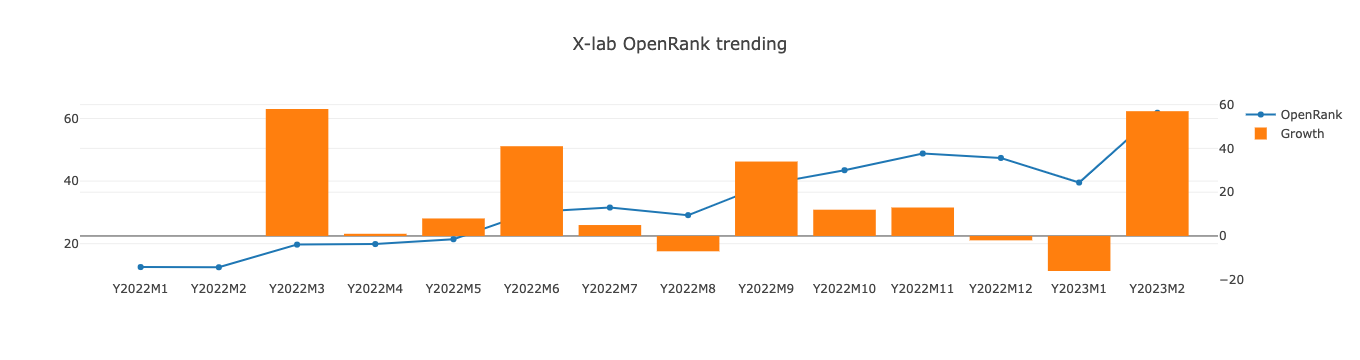

2022.7 based growth: 0.40,0.40,0.62,0.63,0.68,0.96,1.00,0.92,1.23,1.38,1.55,1.50,1.25,1.96


In [2]:
openDigger.index.openrank.getRepoOpenrank({
    repoIds: [288431943, 470364208, 467768946, 461374162, 471252840, 477937218, 428629051, 262909684, 221379769, 259035151, 358757145, 502755745, 508325123, 533339106, 572845686 ],
    startYear, startMonth,
    endYear, endMonth, percision: 2,
    groupTimeRange: 'month', limit: -1, order: 'DESC',
}).then(data => {
    var x = [], v = [], g = []; g.push(0);
    forEveryMonth((y, m, index) => {
        var key = `Y${y}M${m}`;
        x.push(key); v.push(0);
        data.forEach(row => { v[index] += (row.openrank[index] ? row.openrank[index] : 0); row[key] = row.openrank[index] ? row.openrank[index] : 0; });
        if (index > 0) g.push(Math.ceil((v[index]-v[index-1])*100/v[index-1]));
    });
    data.forEach(row => { delete row.openrank; delete row.org; });
    console.table(data);
    openDigger.render.plotly([
        { x, y: v, type: 'scatter', name: 'OpenRank' },
        { x, y: g, type: 'bar', yaxis: 'y2', name: 'Growth'}
    ], {
        title: 'X-lab OpenRank trending',
        yaxis2: { overlaying: 'y', side: 'right' }
    });
    console.log(`2022.7 based growth: ${v.map(i => (i/v[6]).toFixed(2))}`);
    fs.writeFileSync('all_data.json', JSON.stringify(data));
});

## OpenRank Distribution

The OpenRank distribution for certain month is calculated by every repo with OpenRank in this month and all the developers' OpenRank in these repos in this month.

The algorithm means:

- If you contribute to a high OpenRank repo, your final OpenRank may higher.
- If you contribute more in any repo, your final OpenRank may higher.
- If you have a high OpenRank in a certain repo, make the repo's OpenRank higher, your OpenRank will be higher.

So please contribute more and contribute to the important repos, or make your own repo important.

In [4]:
var calculateOpenRankDistribution = (y, m, base) => {
    var actors = openDigger.label.getGitHubData([':communities/xlab']).githubUsers;
    var key = `Y${y}M${m}`;
    var repos = JSON.parse(fs.readFileSync('all_data.json').toString()).filter(row => row[key] > 0);
    var actorOpenrankMap = new Map();
    var actorLoginMap = new Map();
    var repoArr = [];
    var nextMonth = new Date(`${y}-${m}-1`);
    nextMonth.setMonth(nextMonth.getMonth() + 1);
    actors.forEach(id => actorOpenrankMap.set(id, 0));
    Promise.all(repos.map(r => {
        return new Promise(resolve => {
            var sql = `MATCH (u:User)
            WHERE apoc.any.property(u, 'open_rank_${r.id}_${y}${m}') > 0
            AND EXISTS { MATCH (u)-[a:ACTION]->()-[:BELONG]->(r:Repo{id:${r.id}}) WHERE datetime({year:${nextMonth.getFullYear()},month:${nextMonth.getMonth() + 1}})>datetime(a.time)>=datetime({year:${y},month:${m}}) }
            RETURN u.id AS id, u.login AS login, apoc.any.property(u, 'open_rank_${r.id}_${y}${m}') AS openrank`;
            openDigger.driver.neo4j.query(sql).then(data => {
                var total = 0;
                var devs = [];
                data.forEach(item => total += item.openrank);
                data.filter(item => actors.includes(item.id)).forEach(item => {
                    actorLoginMap.set(item.id, item.login);
                    var openrank = item.openrank / total;
                    actorOpenrankMap.set(item.id, actorOpenrankMap.get(item.id) + r[key] * openrank);
                    devs.push({login: item.login, openrank });
                });
                if (devs.length > 0)
                    repoArr.push({ name: r.name, openrank: r[key], devsOrigin: devs, devs: devs.sort((a, b) => b.openrank - a.openrank).map(i => `${i.login}(${(i.openrank*100).toFixed(2)}%)`).join(',')});
                resolve();
            });
        });
    })).then(() => {
        var arr = [];
        var total = 0;
        for (var [ id, openrank ] of actorOpenrankMap.entries()) {
            arr.push({login: actorLoginMap.get(id), openrank});
            total += openrank;
        }
        repoArr.sort((a,b) => b.openrank - a.openrank).forEach(r => console.log(r.name, r.openrank, r.devs));
        console.table(arr.map(i => { return { ...i, ratio: (i.openrank*100/total).toFixed(2) + '%', final: Math.round(i.openrank * base / total) } }).filter(i => i.login).sort((a, b) => b.openrank - a.openrank));
        var detail = {};
        if (fs.existsSync('./detail.json')) detail = JSON.parse(fs.readFileSync('./detail.json').toString());
        detail[`${y}-${m}`] = {
            total: arr.filter(i => i.login).sort((a, b) => b.openrank - a.openrank),
            detail: repoArr.map(r => { return { name: r.name, openrank: r.openrank, actors: r.devsOrigin }; }),
        }
        fs.writeFileSync('./detail.json', JSON.stringify(detail));
    });
};

## The OpenRank distibution

In [4]:
calculateOpenRankDistribution(2022, 6, 10000);

X-lab2017/open-research 7.83 will-ww(39.31%),birdflyi(26.48%),xiaoya-yaya(8.51%),frank-zsy(5.93%),JingbenShi668(4.10%),bifenglin(4.07%),zhuxiangning(3.86%),kongzhongsanbu(3.07%),wengzhenjie(1.61%),AliceCodeZhang(1.56%),tyn1998(1.04%),gymgym1212(0.27%),longyanz(0.02%)
X-lab2017/open-digger 7.67 frank-zsy(65.45%),xiaoya-yaya(12.91%),Best-Eminem(2.11%),xgdyp(0.59%),gymgym1212(0.53%),bifenglin(0.13%),wengzhenjie(0.12%),birdflyi(0.12%),zhicheng-ning(0.12%),chunchill(0.12%),soobun(0.12%),wangleo61(0.12%),kongzhongsanbu(0.01%),tyn1998(0.01%)
hypertrons/hypertrons-crx 7.65 tyn1998(58.16%),zhicheng-ning(5.78%),wxharry(3.73%),xgdyp(2.41%),frank-zsy(0.86%),will-ww(0.18%)
X-lab2017/open-leaderboard 2.19 gymgym1212(88.89%),will-ww(6.61%),tyn1998(2.67%),frank-zsy(0.04%)
X-lab2017/open-wonderland 1.85 will-ww(35.71%),xiaoya-yaya(23.47%),soobun(16.31%),xgdyp(15.39%),tyn1998(3.96%),gymgym1212(3.29%),zhuxiangning(0.93%),zhicheng-ning(0.93%)
X-lab2017/open-perf 0.93 bifenglin(65.75%),will-ww(33.72%),fran

In [5]:
calculateOpenRankDistribution(2022, 7, 10000);

X-lab2017/open-digger 9.17 frank-zsy(65.51%),yoyo-wu98(6.17%),longyanz(3.84%),xiaoya-yaya(2.48%),Best-Eminem(1.05%),zhuxiangning(0.15%),xgdyp(0.11%),zhicheng-ning(0.02%)
hypertrons/hypertrons-crx 8.18 tyn1998(70.13%),wxharry(9.13%),zhicheng-ning(2.99%),xgdyp(2.24%),frank-zsy(1.59%),will-ww(0.84%)
X-lab2017/open-wonderland 5.46 will-ww(63.40%),bifenglin(13.14%),xiaoya-yaya(10.21%),xgdyp(1.56%),frank-zsy(0.63%),birdflyi(0.63%),JingbenShi668(0.63%),kongzhongsanbu(0.63%),longyanz(0.63%),wangleo61(0.63%),yoyo-wu98(0.63%),tyn1998(0.40%),gymgym1212(0.33%),zhicheng-ning(0.09%)
X-lab2017/open-research 3.71 will-ww(50.34%),bifenglin(24.69%),yoyo-wu98(9.36%),xgdyp(0.81%)
X-lab2017/open-leaderboard 1.97 gymgym1212(72.48%),will-ww(27.52%)
OpenEduTech/EduTechResearch 0.7 soobun(46.59%),will-ww(45.15%),AliceCodeZhang(8.26%)
X-lab2017/open-perf 0.48 bifenglin(84.39%),will-ww(15.61%)
┌─────────┬──────────────────┬──────────────────────┬──────────┬───────┐
│ (index) │      login       │       openrank  

In [6]:
calculateOpenRankDistribution(2022, 8, 10000);

X-lab2017/open-digger 8.53 frank-zsy(51.64%),Best-Eminem(10.21%),longyanz(6.22%),PureNatural(5.16%),xiaoya-yaya(3.48%)
X-lab2017/open-wonderland 6.82 xiaoya-yaya(30.91%),will-ww(28.90%),birdflyi(11.09%),bifenglin(6.94%),wangleo61(4.09%),tyn1998(3.02%),zhicheng-ning(3.01%),xgdyp(2.86%)
hypertrons/hypertrons-crx 6.19 tyn1998(34.77%),wxharry(23.96%),frank-zsy(6.68%)
X-lab2017/open-research 3.16 will-ww(100.00%)
X-lab2017/open-perf 0.71 will-ww(80.85%),bifenglin(19.15%)
OpenEduTech/EduTechResearch 0.61 AliceCodeZhang(100.00%)
┌─────────┬──────────────────┬────────────────────┬──────────┬───────┐
│ (index) │      login       │      openrank      │  ratio   │ final │
├─────────┼──────────────────┼────────────────────┼──────────┼───────┤
│    0    │    'will-ww'     │ 5.705002291277674  │ '26.83%' │ 2683  │
│    1    │   'frank-zsy'    │ 4.818754001726496  │ '22.66%' │ 2266  │
│    2    │  'xiaoya-yaya'   │ 2.4050555420778377 │ '11.31%' │ 1131  │
│    3    │    'tyn1998'     │ 2.3583630847980

In [7]:
calculateOpenRankDistribution(2022, 9, 12300);

X-lab2017/open-digger 9.96 frank-zsy(43.29%),xgdyp(15.05%),zhicheng-ning(4.64%),Best-Eminem(2.81%),PureNatural(0.73%),JingbenShi668(0.19%),tyn1998(0.19%),wxharry(0.19%),AliceCodeZhang(0.19%),tvbboy(0.19%),will-ww(0.09%)
X-lab2017/open-research 8.01 xiaoya-yaya(32.32%),will-ww(26.11%),frank-zsy(13.90%),birdflyi(10.20%),xgdyp(4.06%),bifenglin(3.24%),yoyo-wu98(1.23%),zhicheng-ning(0.90%),longyanz(0.67%),lucky-xmyu(0.67%),wj23027(0.67%),lhbvvvvv(0.67%),andyhuang18(0.67%),wengzhenjie(0.62%),gymgym1212(0.11%)
hypertrons/hypertrons-crx 6.95 tyn1998(33.56%),wxharry(19.91%),frank-zsy(1.48%),zhicheng-ning(1.16%)
X-lab2017/open-wonderland 5.18 will-ww(47.76%),bifenglin(29.82%),xgdyp(16.38%),tyn1998(6.04%)
OpenEduTech/EduTechResearch 3.17 AliceCodeZhang(58.12%),lijinlus(13.71%),will-ww(9.61%),foursevenlove(4.07%),lucky-xmyu(0.78%),wj23027(0.78%)
OpenEduTech/OpenEduKG 2.5 will-ww(33.21%),blackburnnnn(18.15%),tvbboy(13.31%),AliceCodeZhang(0.60%)
┌─────────┬──────────────────┬──────────────────────┬─

In [8]:
calculateOpenRankDistribution(2022, 10, 13800);

hypertrons/hypertrons-crx 13.01 tyn1998(28.32%),andyhuang18(15.83%),wj23027(7.50%),wxharry(6.88%),frank-zsy(5.62%),Zzzzzhuzhiwei(4.41%),zhicheng-ning(3.66%),xgdyp(1.07%),will-ww(0.11%)
X-lab2017/open-digger 11.84 xgdyp(27.53%),frank-zsy(23.91%),zhicheng-ning(7.48%),yoyo-wu98(7.33%),will-ww(6.60%),lhbvvvvv(2.16%),bifenglin(0.82%),tyn1998(0.67%),xiaoya-yaya(0.31%),foursevenlove(0.15%),lijinlus(0.15%),blackburnnnn(0.15%),betaberry(0.15%),19883235(0.15%),Kx-Chen-99(0.15%),Zzzzzhuzhiwei(0.15%)
X-lab2017/open-research 7.69 will-ww(27.02%),xiaoya-yaya(26.54%),bifenglin(19.68%),birdflyi(14.69%),xgdyp(5.41%),PureNatural(4.16%),frank-zsy(1.46%),wangleo61(0.91%),tyn1998(0.13%)
OpenEduTech/EduTechResearch 4.19 19883235(35.53%),foursevenlove(35.30%),AliceCodeZhang(14.80%),Kx-Chen-99(6.87%),lijinlus(5.17%),will-ww(0.73%),tyn1998(0.40%),zhicheng-ning(0.40%)
OpenEduTech/OpenEduKG 2.15 tvbboy(49.62%),will-ww(25.83%),blackburnnnn(11.84%)
X-lab2017/open-wonderland 2.13 will-ww(47.40%),bifenglin(32.34%),z

In [9]:
calculateOpenRankDistribution(2022, 11, 15500);

hypertrons/hypertrons-crx 15.39 tyn1998(27.03%),wj23027(10.29%),frank-zsy(8.88%),andyhuang18(7.71%),Zzzzzhuzhiwei(6.02%),will-ww(3.72%),wxharry(2.02%),xgdyp(1.83%),zhicheng-ning(0.60%),lhbvvvvv(0.20%)
X-lab2017/open-digger 14.65 frank-zsy(44.88%),xgdyp(25.51%),longyanz(7.07%),will-ww(3.24%),zhicheng-ning(2.28%),lucky-xmyu(0.70%),bifenglin(0.65%),lhbvvvvv(0.26%),Best-Eminem(0.21%),birdflyi(0.12%),tyn1998(0.08%),xiaoya-yaya(0.04%)
OpenEduTech/EduTechResearch 5.87 19883235(29.75%),foursevenlove(23.68%),lijinlus(16.63%),AliceCodeZhang(9.35%),Kx-Chen-99(4.57%),will-ww(4.27%)
X-lab2017/open-research 5.87 yoyo-wu98(22.20%),bifenglin(20.60%),xiaoya-yaya(12.38%),birdflyi(11.76%),will-ww(11.10%),tyn1998(7.52%),xgdyp(7.33%),zhicheng-ning(3.65%),longyanz(2.19%)
X-lab2017/open-wonderland 3.62 bifenglin(43.55%),zhicheng-ning(25.39%),tyn1998(10.07%),will-ww(9.73%),PureNatural(9.08%)
OpenEduTech/OpenEduKG 1.5 tvbboy(69.88%),blackburnnnn(30.12%)
X-lab2017/open-perf 0.55 will-ww(50.34%),bifenglin(49.66%

In [4]:
calculateOpenRankDistribution(2022, 12, 14300);

X-lab2017/open-digger 19.36 frank-zsy(42.64%),xgdyp(16.73%),longyanz(11.20%),zhicheng-ning(3.49%),tyn1998(3.22%),PureNatural(2.97%),birdflyi(1.78%),bifenglin(0.99%),xiaoya-yaya(0.55%)
hypertrons/hypertrons-crx 10.02 tyn1998(41.77%),lhbvvvvv(10.58%),frank-zsy(9.77%),wxharry(3.72%)
OpenEduTech/EduTechResearch 4.33 19883235(43.31%),AliceCodeZhang(21.11%),lijinlus(18.23%),Kx-Chen-99(17.35%)
X-lab2017/open-research 3.89 xiaoya-yaya(70.10%),will-ww(10.94%),xgdyp(7.87%),lhbvvvvv(6.49%),birdflyi(4.59%)
X-lab2017/open-wonderland 3.84 zhicheng-ning(35.83%),xgdyp(30.89%),will-ww(19.14%),frank-zsy(9.07%)
┌─────────┬──────────────────┬─────────────────────┬──────────┬───────┐
│ (index) │      login       │      openrank       │  ratio   │ final │
├─────────┼──────────────────┼─────────────────────┼──────────┼───────┤
│    0    │   'frank-zsy'    │  9.582714119641707  │ '27.66%' │ 3955  │
│    1    │    'tyn1998'     │  4.809405174325107  │ '13.88%' │ 1985  │
│    2    │     'xgdyp'      │  4.731276

In [5]:
calculateOpenRankDistribution(2023, 1, 12200);

X-lab2017/open-digger 19.9 frank-zsy(46.68%),xgdyp(10.51%),PureNatural(3.82%),birdflyi(3.47%),bifenglin(1.98%),tyn1998(1.72%),xiaoya-yaya(1.22%),zhicheng-ning(1.04%),will-ww(0.75%),wangleo61(0.28%)
hypertrons/hypertrons-crx 7.04 tyn1998(36.97%),wxharry(9.16%),frank-zsy(6.77%),andyhuang18(3.11%),wj23027(2.74%),zhicheng-ning(0.93%)
X-lab2017/open-wonderland 2.65 will-ww(38.08%),zhicheng-ning(32.52%),PureNatural(14.02%),bifenglin(12.66%)
X-lab2017/open-research 2.18 xiaoya-yaya(66.51%)
┌─────────┬─────────────────┬─────────────────────┬──────────┬───────┐
│ (index) │      login      │      openrank       │  ratio   │ final │
├─────────┼─────────────────┼─────────────────────┼──────────┼───────┤
│    0    │   'frank-zsy'   │   9.7649981214232   │ '43.50%' │ 5307  │
│    1    │    'tyn1998'    │ 2.9455644366777736  │ '13.12%' │ 1601  │
│    2    │     'xgdyp'     │ 2.0906027973611976  │ '9.31%'  │ 1136  │
│    3    │  'xiaoya-yaya'  │ 1.6923163390040263  │ '7.54%'  │  920  │
│    4    │    

In [5]:
calculateOpenRankDistribution(2023, 2, 19600);

X-lab2017/open-digger 40.48 frank-zsy(44.23%),xgdyp(10.01%),tyn1998(4.31%),xiaoya-yaya(3.89%),will-ww(1.44%),zhicheng-ning(0.53%),Miaheeee(0.27%),lucky-lcy-best(0.08%),wj23027(0.08%),andyhuang18(0.08%),lhbvvvvv(0.05%),Zzzzzhuzhiwei(0.04%)
hypertrons/hypertrons-crx 5.69 tyn1998(52.65%),wxharry(8.67%),lhbvvvvv(4.20%),wj23027(3.56%),frank-zsy(1.05%)
X-lab2017/open-leaderboard 3.83 tyn1998(38.40%),wj23027(20.23%),andyhuang18(19.22%),zhicheng-ning(10.68%),will-ww(7.80%),frank-zsy(1.65%),bifenglin(0.64%)
X-lab2017/open-wonderland 2.37 will-ww(51.62%),zhicheng-ning(27.87%),xgdyp(12.75%),frank-zsy(3.34%),tyn1998(1.56%)
X-lab2017/open-galaxy 2.18 tyn1998(78.90%),frank-zsy(6.86%)
X-lab2017/od-api 0.55 zhicheng-ning(100.00%)
┌─────────┬──────────────────┬──────────────────────┬──────────┬───────┐
│ (index) │      login       │       openrank       │  ratio   │ final │
├─────────┼──────────────────┼──────────────────────┼──────────┼───────┤
│    0    │   'frank-zsy'    │  18.25679135051986   │ '47